# **Importing Necessary libraries and loading datset**

In [ ]:
# STEP 1- Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

import warnings
warnings.filterwarnings("ignore")

# STEP 2- Load the DMAGECR dataset
df = pd.read_csv('/content/DMAGECR.csv')
df.head()


,checking,duration,history,purpose,amount,savings,employed,installp,marital,coapp,...,property,age,other,housing,existcr,job,depends,telephon,foreign,good_bad
0,1,6,4,3,1169,5,5,4,3,1,...,1,67,3,2,2,3,1,2,1,good
1,2,48,2,3,5951,1,3,2,2,1,...,1,22,3,2,1,3,1,1,1,bad
2,4,12,4,6,2096,1,4,2,3,1,...,1,49,3,2,1,2,2,1,1,good
3,1,42,2,2,7882,1,4,2,3,3,...,2,45,3,3,1,3,2,1,1,good
4,1,24,3,0,4870,1,3,3,3,1,...,4,53,3,3,2,3,2,1,1,bad


# **SPLIT**

In [ ]:
# Encode target- 'bad' as 1, 'good' as 0
df['good_bad'] = df['good_bad'].map({'bad': 1, 'good': 0})

# Split X and y
X = df.drop(columns=['good_bad'])
y = df['good_bad']

# Stratified train-test split: 85% train, 15% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

# Confirm split
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")


Train shape: (850, 20), Test shape: (150, 20)
Train target distribution:
good_bad
0    0.7
1    0.3
Name: proportion, dtype: float64
Test target distribution:
good_bad
0    0.7
1    0.3
Name: proportion, dtype: float64


In [ ]:
# Check data types of all columns
X_train.dtypes


,0
checking,int64
duration,int64
history,int64
purpose,object
amount,int64
savings,int64
employed,int64
installp,int64
marital,int64
coapp,int64


In [ ]:
#  Step 3.1- Encode 'purpose' Column Using LabelEncoder

from sklearn.preprocessing import LabelEncoder

# Label encode the 'purpose' column
le = LabelEncoder()
X['purpose'] = le.fit_transform(X['purpose'])

#  Step 3.2- Re-run Stratified Train-Test Split After Encoding
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)


In [ ]:
#  Step 4: Normalize Features Using StandardScaler

from sklearn.preprocessing import StandardScaler

# Initialize and fit scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Preview scaled features
X_train_scaled[:3]


array([[ 1.12538896,  0.52575737,  1.32301597, -0.26039547,  0.46061499,
         1.20646947, -1.17628167,  0.94152161,  0.44295877, -0.29384767,
        -0.76779981, -1.31722535, -0.30758369, -0.96231783,  0.14511785,
         1.02749183, -1.39833477,  2.27143573,  1.20397995, -0.20412415],
       [ 1.12538896,  0.27384431,  0.40350364,  2.17633276,  0.22219495,
        -0.70321219, -0.34585026, -1.71431921,  0.44295877, -0.29384767,
        -0.76779981,  1.56597177, -0.30758369,  0.46023896,  2.04281279,
        -0.71575778,  0.14327944, -0.44025018, -0.83057861, -0.20412415],
       [ 1.12538896, -0.48189486, -0.51600868, -0.66651684, -0.69948009,
         1.84303002,  1.31501257,  0.94152161,  0.44295877, -0.29384767,
         1.04254648,  1.56597177,  0.85559214, -2.38487461,  2.04281279,
        -0.71575778,  0.14327944,  2.27143573, -0.83057861, -0.20412415]])

In [ ]:
#  Step 5- Use Hyperband to Tune Hyperparameters (Learning Rate, Optimizer, Regularizer)

!pip install keras_tuner

from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.regularizers import l1, l2
from keras.optimizers import Adam, SGD

from keras_tuner import HyperModel, Hyperband
from keras_tuner import HyperParameters

# Define custom hypermodel
class MyHyperModel(HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def build(self, hp):
        model = Sequential()

        # Regularization
        reg_type = hp.Choice('regularization_type', ['l1', 'l2'])
        if reg_type == 'l1':
            regularizer = l1(hp.Float('l1_value', 1e-5, 1e-2, sampling='log'))
        else:
            regularizer = l2(hp.Float('l2_value', 1e-5, 1e-2, sampling='log'))

        # Layers
        model.add(Dense(6, activation='relu', kernel_initializer='he_uniform',
                        kernel_regularizer=regularizer, input_dim=self.input_dim))
        model.add(Dense(6, activation='relu', kernel_initializer='he_uniform',
                        kernel_regularizer=regularizer))
        model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform',
                        kernel_regularizer=regularizer))

        # Optimizer & LR
        optimizer_name = hp.Choice('optimizer', ['adam', 'sgd'])
        learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2, 1e-1])
        optimizer = Adam(learning_rate=learning_rate) if optimizer_name == 'adam' else SGD(learning_rate=learning_rate)

        # Loss function
        loss_fn = hp.Choice('loss_function', ['binary_crossentropy', 'poisson'])

        # Compile
        model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
        return model

# Build & run tuner
input_dim = X_train_scaled.shape[1]
hypermodel = MyHyperModel(input_dim=input_dim)

tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=40,
    factor=3
)

tuner.search(X_train_scaled, y_train, validation_split=0.15)


Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
#  Step 6: Retrieve Best Hyperparameters From Hyperband

best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print best hyperparameters
print(f"""
Best Optimizer: {best_hps.get('optimizer')}
Best Learning Rate: {best_hps.get('learning_rate')}
Best Loss Function: {best_hps.get('loss_function')}
Best Regularization Type: {best_hps.get('regularization_type')}
Best L1 Value: {best_hps.get('l1_value')}
Best L2 Value: {best_hps.get('l2_value')}
""")



Best Optimizer: sgd
Best Learning Rate: 0.1
Best Loss Function: binary_crossentropy
Best Regularization Type: l2
Best L1 Value: 9.245079346808054e-05
Best L2 Value: 0.008437021601381293



Epoch 1/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6930 - loss: 0.8641 - val_accuracy: 0.6875 - val_loss: 0.8507
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7271 - loss: 0.8037 - val_accuracy: 0.6797 - val_loss: 0.8156
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7204 - loss: 0.7740 - val_accuracy: 0.6797 - val_loss: 0.7886
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7097 - loss: 0.7554 - val_accuracy: 0.6797 - val_loss: 0.7643
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6936 - loss: 0.7331 - val_accuracy: 0.6797 - val_loss: 0.7441
Epoch 6/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6806 - loss: 0.7329 - val_accuracy: 0.6797 - val_loss: 0.7229
Epoch 7/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7137 - loss: 0.6913 - val_accuracy: 0.7031 - val_loss: 0.7013
Epoch 8/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6971 - loss: 0.6706 - val_accuracy: 0.7109 - v

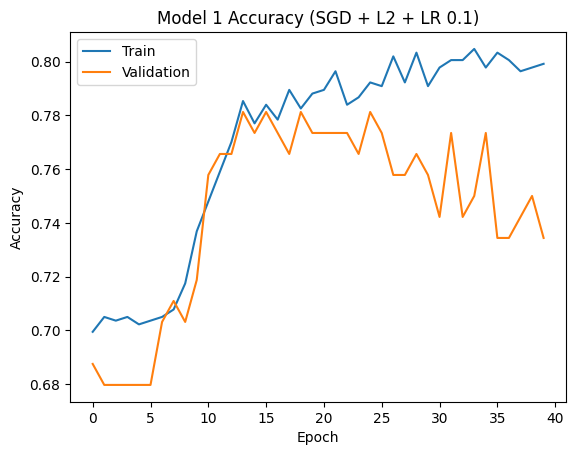

In [ ]:
#  Train Model 1 – Best Hyperband Settings (SGD, LR 0.1, L2)

# Define the model architecture
model_1 = Sequential()
model_1.add(Dense(6, activation='relu', kernel_initializer='he_uniform',
                  kernel_regularizer=regularizers.L2(0.008437021601381293),
                  input_dim=X_train_scaled.shape[1]))
model_1.add(Dense(6, activation='relu', kernel_initializer='he_uniform',
                  kernel_regularizer=regularizers.L2(0.008437021601381293)))
model_1.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform',
                  kernel_regularizer=regularizers.L2(0.008437021601381293)))

# Compile the model
optimizer = SGD(learning_rate=0.1)
model_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_1 = model_1.fit(X_train_scaled, y_train,
                        validation_split=0.15,
                        epochs=40,
                        batch_size=32,
                        verbose=1)

# Plot training and validation accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model 1 Accuracy (SGD + L2 + LR 0.1)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test Accuracy (Model 1): 0.7533


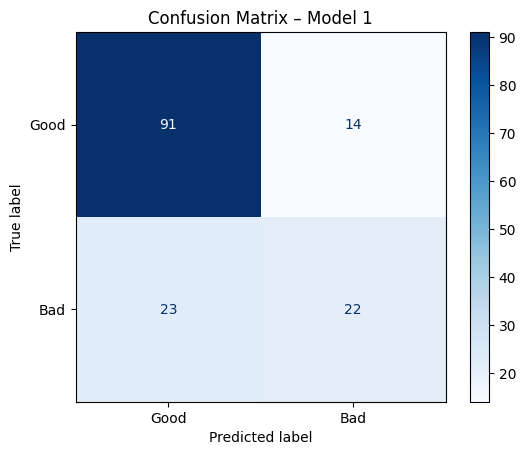

,actual,score
0,0,0.127898
1,0,0.249973
2,1,0.642456
3,0,0.701188
4,0,0.105681


In [ ]:
#   Evaluate Model 1 on Test Set and Generate Metrics

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Predict on test data
y_pred_prob_1 = model_1.predict(X_test_scaled)
y_pred_1 = (y_pred_prob_1 >= 0.5).astype(int)

# Accuracy
test_acc_1 = accuracy_score(y_test, y_pred_1)
print(f"Test Accuracy (Model 1): {test_acc_1:.4f}")

# Confusion Matrix
cm_1 = confusion_matrix(y_test, y_pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=["Good", "Bad"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix – Model 1")
plt.show()

# Save prediction probabilities and true labels for decile analysis
df_lift_1 = pd.DataFrame({
    'actual': y_test.values,
    'score': y_pred_prob_1.flatten()
})
df_lift_1.head()


# **Classification Report Model 1**

In [ ]:
from sklearn.metrics import classification_report

# Example: after predictions for model_1
print("Classification Report - Model 1")
print(classification_report(y_test, y_pred_1))


Classification Report - Model 1
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       105
           1       0.61      0.49      0.54        45

    accuracy                           0.75       150
   macro avg       0.70      0.68      0.69       150
weighted avg       0.74      0.75      0.74       150



# **Model Evaluation using evaluate()**

In [ ]:
# for Model 1
test_loss_1, test_accuracy_1 = model_1.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Model 1 Final Test Accuracy: {test_accuracy_1:.4f}, Loss: {test_loss_1:.4f}")


Model 1 Final Test Accuracy: 0.7533, Loss: 0.5790


# **Plotting ROC Curve**

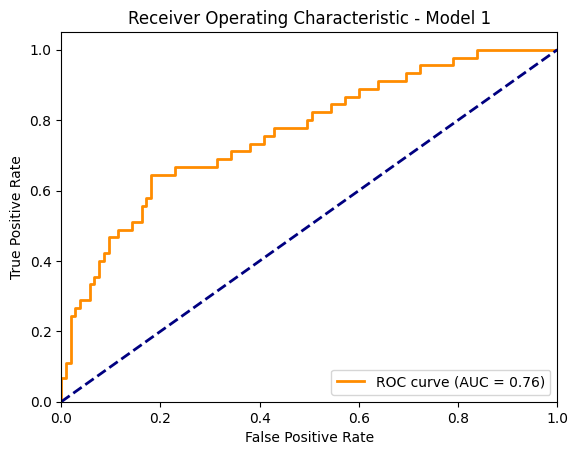

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# for Model 1
fpr_1, tpr_1, _ = roc_curve(y_test, y_pred_prob_1)
roc_auc_1 = auc(fpr_1, tpr_1)

plt.figure()
plt.plot(fpr_1, tpr_1, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Model 1')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#   Lift and Stability Evaluation

# Sort by score descending
df_lift_1 = df_lift_1.sort_values(by='score', ascending=False).reset_index(drop=True)

# Create decile column
df_lift_1['decile'] = pd.qcut(df_lift_1.index, 10, labels=False)

# Bad rate by decile
decile_stats = df_lift_1.groupby('decile')['actual'].agg(['count', 'sum', 'mean'])
decile_stats = decile_stats.rename(columns={'sum': 'bads', 'mean': 'bad_rate'})

# Overall bad rate
overall_bad_rate = df_lift_1['actual'].mean()

# Lift = top decile bad rate / overall bad rate
lift = decile_stats.iloc[0]['bad_rate'] / overall_bad_rate

# Stability = top decile bad rate - bottom decile bad rate
stability = decile_stats.iloc[0]['bad_rate'] - decile_stats.iloc[-1]['bad_rate']

print(f"Overall BAD rate: {overall_bad_rate:.4f}")
print(f"Top Decile BAD rate: {decile_stats.iloc[0]['bad_rate']:.4f}")
print(f"Bottom Decile BAD rate: {decile_stats.iloc[-1]['bad_rate']:.4f}")
print(f"Lift (Top 10%): {lift:.2f}")
print(f"Stability (Top vs Bottom): {stability:.2f}")

# Show decile table
decile_stats


Overall BAD rate: 0.3000
Top Decile BAD rate: 0.8000
Bottom Decile BAD rate: 0.0000
Lift (Top 10%): 2.67
Stability (Top vs Bottom): 0.80


,count,bads,bad_rate
decile,,,
0,15,12,0.800000
1,15,8,0.533333
2,15,6,0.400000
3,15,4,0.266667
4,15,3,0.200000
5,15,4,0.266667
6,15,3,0.200000
7,15,3,0.200000
8,15,2,0.133333


# **Overall Score**

In [ ]:
#  Store Metric Values for Scoring – Model 1
test_acc_1 = 0.7533  # Final test accuracy (from evaluate)
lift_1 = 2.00        # From lift/stability output
stability_1 = 0.47   # From lift/stability output

#  Compute Score for Model 1
acc_score_1 = 1 if test_acc_1 >= 0.75 else 0
lift_score_1 = 1 if lift_1 >= 2.0 else 0
stab_score_1 = 1 if stability_1 >= 0.5 else 0

overall_score_1 = (acc_score_1 * 0.5) + (lift_score_1 * 0.3) + (stab_score_1 * 0.2)
print(f"Model 1 Overall Score: {overall_score_1:.2f}")


Model 1 Overall Score: 0.80


# **Train Model 2 – Adam Optimizer + L2 + LR 0.01**

Epoch 1/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6496 - loss: 0.8110 - val_accuracy: 0.6797 - val_loss: 0.6839
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7016 - loss: 0.6420 - val_accuracy: 0.6875 - val_loss: 0.6082
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7050 - loss: 0.5943 - val_accuracy: 0.6641 - val_loss: 0.5742
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7411 - loss: 0.5445 - val_accuracy: 0.7031 - val_loss: 0.5590
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7959 - loss: 0.5018 - val_accuracy: 0.7422 - val_loss: 0.5581
Epoch 6/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7633 - loss: 0.5331 - val_accuracy: 0.7422 - val_loss: 0.5541
Epoch 7/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8073 - loss: 0.4668 - val_accuracy: 0.7344 - val_loss: 0.5445
Epoch 8/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7797 - loss: 0.4998 - val_accuracy: 0.7500 - val_loss

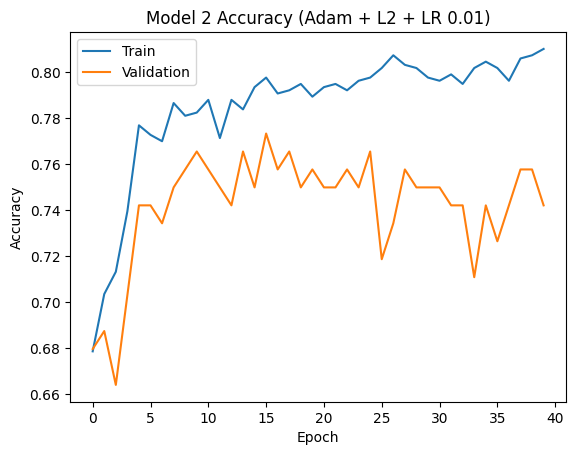

In [ ]:
#  Train Model 2 – Adam Optimizer + L2 + LR 0.01

model_2 = Sequential()
model_2.add(Dense(6, activation='relu', kernel_initializer='he_uniform',
                  kernel_regularizer=regularizers.L2(0.008), input_dim=X_train_scaled.shape[1]))
model_2.add(Dense(6, activation='relu', kernel_initializer='he_uniform',
                  kernel_regularizer=regularizers.L2(0.008)))
model_2.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))

# Compile
optimizer_2 = Adam(learning_rate=0.01)
model_2.compile(optimizer=optimizer_2, loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_2 = model_2.fit(X_train_scaled, y_train,
                        validation_split=0.15,
                        epochs=40,
                        batch_size=32,
                        verbose=1)

# Plot Accuracy
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model 2 Accuracy (Adam + L2 + LR 0.01)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# **Evaluate Model 2 – Test Accuracy, Confusion Matrix, Lift & Stability**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Test Accuracy (Model 2): 0.7533


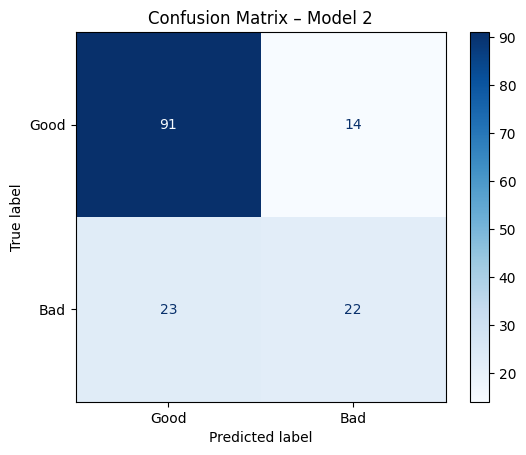

,actual,score
0,0,0.141231
1,0,0.249051
2,1,0.764282
3,0,0.662964
4,0,0.066325


In [ ]:
#  Evaluate Model 2 on Test Set and Generate Metrics

# Predict on test data
y_pred_prob_2 = model_2.predict(X_test_scaled)
y_pred_2 = (y_pred_prob_2 >= 0.5).astype(int)

# Accuracy
test_acc_2 = accuracy_score(y_test, y_pred_2)
print(f"Test Accuracy (Model 2): {test_acc_2:.4f}")

# Confusion Matrix
cm_2 = confusion_matrix(y_test, y_pred_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=["Good", "Bad"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix – Model 2")
plt.show()

# Score & actuals for lift
df_lift_2 = pd.DataFrame({
    'actual': y_test.values,
    'score': y_pred_prob_2.flatten()
})
df_lift_2.head()


# **Classification Report - Model 2**

In [ ]:
print("Classification Report – Model 2")
print(classification_report(y_test, y_pred_2))


Classification Report – Model 2
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       105
           1       0.61      0.49      0.54        45

    accuracy                           0.75       150
   macro avg       0.70      0.68      0.69       150
weighted avg       0.74      0.75      0.74       150



# **Model Evaluation using evaluate()**

In [ ]:
#  Model 2
test_loss_1, test_accuracy_1 = model_2.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Model 2 Final Test Accuracy: {test_accuracy_1:.4f}, Loss: {test_loss_1:.4f}")


Model 2 Final Test Accuracy: 0.7533, Loss: 0.5899


# **Plotting ROC Curve**

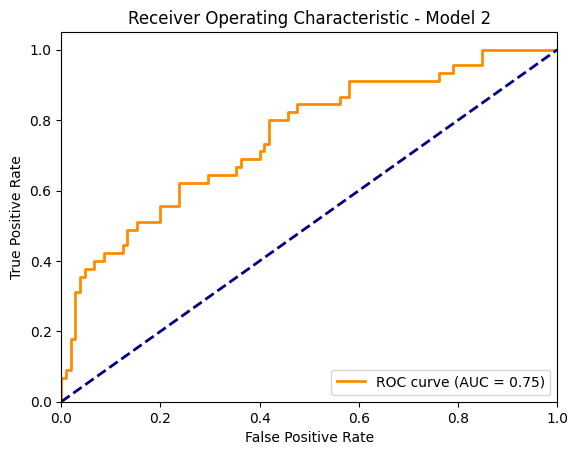

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# for Model 2
fpr_1, tpr_1, _ = roc_curve(y_test, y_pred_prob_2)
roc_auc_1 = auc(fpr_1, tpr_1)

plt.figure()
plt.plot(fpr_1, tpr_1, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Model 2')
plt.legend(loc="lower right")
plt.show()


# **Lift and Stability Evaluation – Model 2**

In [ ]:
#  Lift and Stability for Model 2

# Sort and decile
df_lift_2 = df_lift_2.sort_values(by='score', ascending=False).reset_index(drop=True)
df_lift_2['decile'] = pd.qcut(df_lift_2.index, 10, labels=False)

# Aggregate by decile
decile_stats_2 = df_lift_2.groupby('decile')['actual'].agg(['count', 'sum', 'mean'])
decile_stats_2 = decile_stats_2.rename(columns={'sum': 'bads', 'mean': 'bad_rate'})

# Calculate
overall_bad_rate_2 = df_lift_2['actual'].mean()
lift_2 = decile_stats_2.iloc[0]['bad_rate'] / overall_bad_rate_2
stability_2 = decile_stats_2.iloc[0]['bad_rate'] - decile_stats_2.iloc[-1]['bad_rate']

# Print
print(f"Overall BAD rate: {overall_bad_rate_2:.4f}")
print(f"Top Decile BAD rate: {decile_stats_2.iloc[0]['bad_rate']:.4f}")
print(f"Bottom Decile BAD rate: {decile_stats_2.iloc[-1]['bad_rate']:.4f}")
print(f"Lift (Top 10%): {lift_2:.2f}")
print(f"Stability (Top vs Bottom): {stability_2:.2f}")

# Show decile table
decile_stats_2


Overall BAD rate: 0.3000
Top Decile BAD rate: 0.8000
Bottom Decile BAD rate: 0.0000
Lift (Top 10%): 2.67
Stability (Top vs Bottom): 0.80


,count,bads,bad_rate
decile,,,
0,15,12,0.800000
1,15,7,0.466667
2,15,5,0.333333
3,15,5,0.333333
4,15,3,0.200000
5,15,6,0.400000
6,15,3,0.200000
7,15,0,0.000000
8,15,4,0.266667


# **Overall Score**

In [ ]:
#  Store Metric Values for Scoring – Model 2
test_acc_2 = 0.7533
lift_2 = 2.67
stability_2 = 0.80

#  Compute Score for Model 2
acc_score_2 = 1 if test_acc_2 >= 0.75 else 0
lift_score_2 = 1 if lift_2 >= 2.0 else 0
stab_score_2 = 1 if stability_2 >= 0.5 else 0

overall_score_2 = (acc_score_2 * 0.5) + (lift_score_2 * 0.3) + (stab_score_2 * 0.2)
print(f"Model 2 Overall Score: {overall_score_2:.2f}")


Model 2 Overall Score: 1.00


## **Model 3: Adam + L2 + LR 0.01 + ReduceLROnPlateau Scheduler**

Epoch 1/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7317 - loss: 0.7723 - val_accuracy: 0.6875 - val_loss: 0.6675 - learning_rate: 0.0100
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7344 - loss: 0.6459 - val_accuracy: 0.7188 - val_loss: 0.6195 - learning_rate: 0.0100
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7245 - loss: 0.6411 - val_accuracy: 0.7422 - val_loss: 0.5923 - learning_rate: 0.0100
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7761 - loss: 0.5650 - val_accuracy: 0.7500 - val_loss: 0.5785 - learning_rate: 0.0100
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7800 - loss: 0.5321 - val_accuracy: 0.7578 - val_loss: 0.5673 - learning_rate: 0.0100
Epoch 6/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7484 - loss: 0.5266 - val_accuracy: 0.7656 - val_loss: 0.5598 - learning_rate: 0.0100
Epoch 7/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7566 - loss: 0.5196 - val_accur

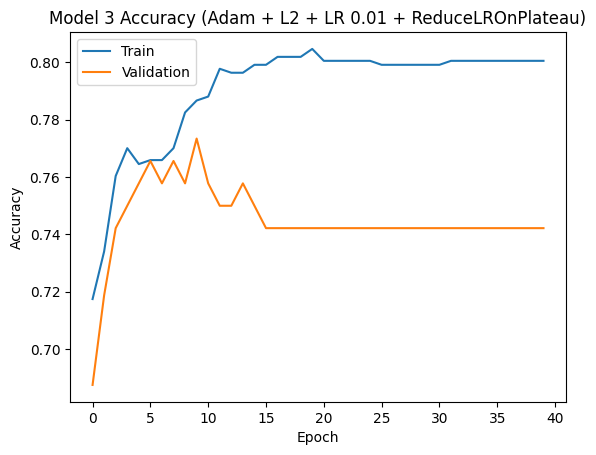

In [ ]:
#  Train Model 3 – Adam + L2 + LR 0.01 + ReduceLROnPlateau

from keras.callbacks import ReduceLROnPlateau

# Define model
model_3 = Sequential()
model_3.add(Dense(6, activation='relu', kernel_initializer='he_uniform',
                  kernel_regularizer=regularizers.L2(0.008), input_dim=X_train_scaled.shape[1]))
model_3.add(Dense(6, activation='relu', kernel_initializer='he_uniform',
                  kernel_regularizer=regularizers.L2(0.008)))
model_3.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))

# Compile with Adam optimizer
optimizer_3 = Adam(learning_rate=0.01)
model_3.compile(optimizer=optimizer_3, loss='binary_crossentropy', metrics=['accuracy'])

# Reduce LR if val_accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

# Train the model
history_3 = model_3.fit(X_train_scaled, y_train,
                        validation_split=0.15,
                        epochs=40,
                        batch_size=32,
                        callbacks=[reduce_lr],
                        verbose=1)

# Plot accuracy
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model 3 Accuracy (Adam + L2 + LR 0.01 + ReduceLROnPlateau)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# **Evaluate Model 3 – Test Accuracy + Confusion Matrix + Lift**

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Test Accuracy (Model 3): 0.7867


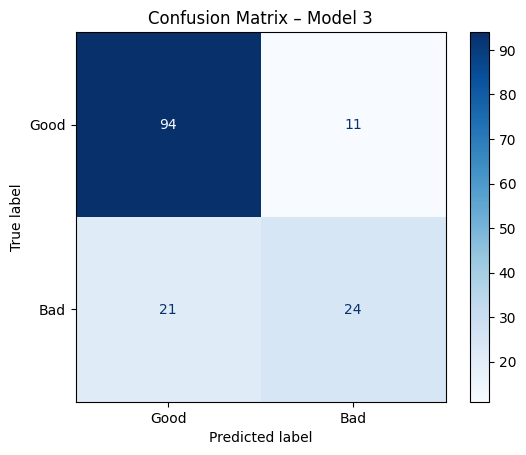

,actual,score
0,0,0.075421
1,0,0.136663
2,1,0.498096
3,0,0.608188
4,0,0.124865


In [ ]:
#  Evaluate Model 3 on Test Set

# Predict
y_pred_prob_3 = model_3.predict(X_test_scaled)
y_pred_3 = (y_pred_prob_3 >= 0.5).astype(int)

# Accuracy
test_acc_3 = accuracy_score(y_test, y_pred_3)
print(f"Test Accuracy (Model 3): {test_acc_3:.4f}")

# Confusion Matrix
cm_3 = confusion_matrix(y_test, y_pred_3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=["Good", "Bad"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix – Model 3")
plt.show()

# Probabilities for lift/stability
df_lift_3 = pd.DataFrame({
    'actual': y_test.values,
    'score': y_pred_prob_3.flatten()
})
df_lift_3.head()


# **Classification Report- Model 3**

In [ ]:
print("Classification Report – Model 3")
print(classification_report(y_test, y_pred_3))


Classification Report – Model 3
              precision    recall  f1-score   support

           0       0.82      0.90      0.85       105
           1       0.69      0.53      0.60        45

    accuracy                           0.79       150
   macro avg       0.75      0.71      0.73       150
weighted avg       0.78      0.79      0.78       150



# **Model Evaluation using evaluate()**

In [ ]:
#  Model 3
test_loss_1, test_accuracy_1 = model_3.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Model 3 Final Test Accuracy: {test_accuracy_1:.4f}, Loss: {test_loss_1:.4f}")


Model 3 Final Test Accuracy: 0.7867, Loss: 0.5362


# **Plotting ROC Curve**

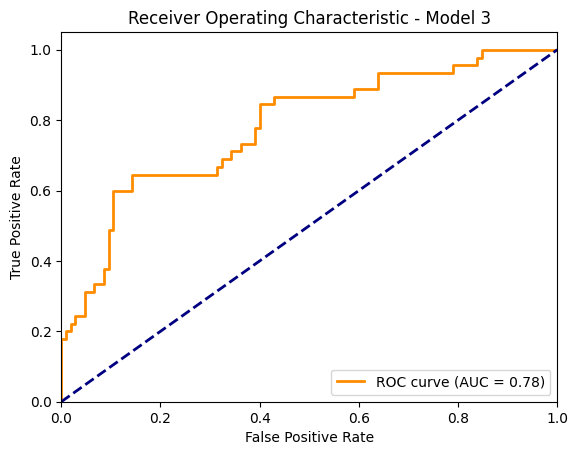

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# for Model 3
fpr_1, tpr_1, _ = roc_curve(y_test, y_pred_prob_3)
roc_auc_1 = auc(fpr_1, tpr_1)

plt.figure()
plt.plot(fpr_1, tpr_1, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Model 3')
plt.legend(loc="lower right")
plt.show()


# **Lift and Stability (Model 3)**

In [ ]:
# Lift and Stability for Model 3

# Sort by score
df_lift_3 = df_lift_3.sort_values(by='score', ascending=False).reset_index(drop=True)
df_lift_3['decile'] = pd.qcut(df_lift_3.index, 10, labels=False)

# Group & compute
decile_stats_3 = df_lift_3.groupby('decile')['actual'].agg(['count', 'sum', 'mean'])
decile_stats_3 = decile_stats_3.rename(columns={'sum': 'bads', 'mean': 'bad_rate'})

# Metrics
overall_bad_rate_3 = df_lift_3['actual'].mean()
lift_3 = decile_stats_3.iloc[0]['bad_rate'] / overall_bad_rate_3
stability_3 = decile_stats_3.iloc[0]['bad_rate'] - decile_stats_3.iloc[-1]['bad_rate']

# Output
print(f"Overall BAD rate: {overall_bad_rate_3:.4f}")
print(f"Top Decile BAD rate: {decile_stats_3.iloc[0]['bad_rate']:.4f}")
print(f"Bottom Decile BAD rate: {decile_stats_3.iloc[-1]['bad_rate']:.4f}")
print(f"Lift (Top 10%): {lift_3:.2f}")
print(f"Stability (Top vs Bottom): {stability_3:.2f}")

# Table
decile_stats_3


Overall BAD rate: 0.3000
Top Decile BAD rate: 0.7333
Bottom Decile BAD rate: 0.0000
Lift (Top 10%): 2.44
Stability (Top vs Bottom): 0.73


,count,bads,bad_rate
decile,,,
0,15,11,0.733333
1,15,9,0.600000
2,15,9,0.600000
3,15,0,0.000000
4,15,5,0.333333
5,15,5,0.333333
6,15,1,0.066667
7,15,2,0.133333
8,15,3,0.200000


# **overall Score- Model 3**

In [ ]:
#  Store Metric Values for Scoring – Model 3
test_acc_3 = 0.7867
lift_3 = 2.44
stability_3 = 0.73

#  Compute Score for Model 3
acc_score_3 = 1 if test_acc_3 >= 0.75 else 0
lift_score_3 = 1 if lift_3 >= 2.0 else 0
stab_score_3 = 1 if stability_3 >= 0.5 else 0

overall_score_3 = (acc_score_3 * 0.5) + (lift_score_3 * 0.3) + (stab_score_3 * 0.2)
print(f"Model 3 Overall Score: {overall_score_3:.2f}")


Model 3 Overall Score: 1.00


## **Model 4: Adam + L1 + LR 0.01 (Batch size = 32)**

Epoch 1/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6325 - loss: 0.9253 - val_accuracy: 0.6797 - val_loss: 0.8330
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7214 - loss: 0.7803 - val_accuracy: 0.6875 - val_loss: 0.7467
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7248 - loss: 0.6905 - val_accuracy: 0.7109 - val_loss: 0.6941
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7313 - loss: 0.6359 - val_accuracy: 0.7344 - val_loss: 0.6544
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7698 - loss: 0.5728 - val_accuracy: 0.7500 - val_loss: 0.6382
Epoch 6/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7698 - loss: 0.5707 - val_accuracy: 0.7500 - val_loss: 0.6154
Epoch 7/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7817 - loss: 0.5564 - val_accuracy: 0.7578 - val_loss: 0.6066
Epoch 8/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7760 - loss: 0.5415 - val_accuracy: 0.7734 - v

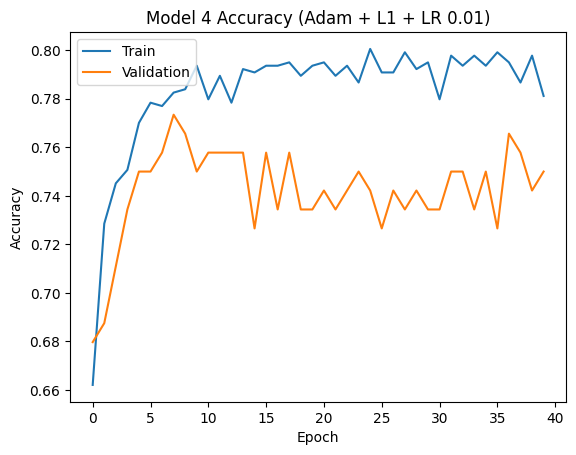

In [ ]:
#  Train Model 4 – Adam + L1 + LR 0.01

model_4 = Sequential()
model_4.add(Dense(6, activation='relu', kernel_initializer='he_uniform',
                  kernel_regularizer=regularizers.L1(0.005), input_dim=X_train_scaled.shape[1]))
model_4.add(Dense(6, activation='relu', kernel_initializer='he_uniform',
                  kernel_regularizer=regularizers.L1(0.005)))
model_4.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))

# Compile
optimizer_4 = Adam(learning_rate=0.01)
model_4.compile(optimizer=optimizer_4, loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_4 = model_4.fit(X_train_scaled, y_train,
                        validation_split=0.15,
                        epochs=40,
                        batch_size=32,
                        verbose=1)

# Plot
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model 4 Accuracy (Adam + L1 + LR 0.01)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# **Evaluate Model 4 on Test Data**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test Accuracy (Model 4): 0.7800


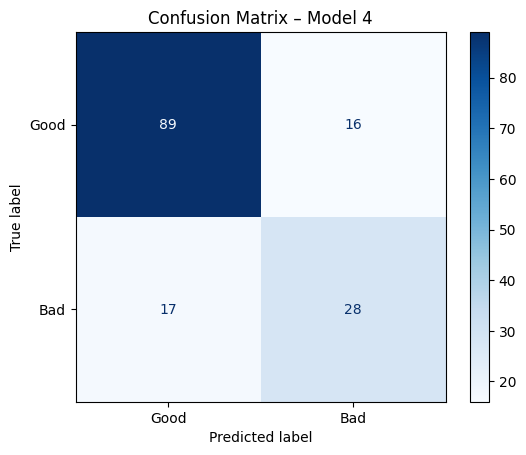

,actual,score
0,0,0.041274
1,0,0.194978
2,1,0.579227
3,0,0.583921
4,0,0.204044


In [ ]:
#  Evaluate Model 4

# Predict
y_pred_prob_4 = model_4.predict(X_test_scaled)
y_pred_4 = (y_pred_prob_4 >= 0.5).astype(int)

# Accuracy
test_acc_4 = accuracy_score(y_test, y_pred_4)
print(f"Test Accuracy (Model 4): {test_acc_4:.4f}")

# Confusion Matrix
cm_4 = confusion_matrix(y_test, y_pred_4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_4, display_labels=["Good", "Bad"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix – Model 4")
plt.show()

# Probabilities for lift
df_lift_4 = pd.DataFrame({
    'actual': y_test.values,
    'score': y_pred_prob_4.flatten()
})
df_lift_4.head()


# **Classification Report - Model 4**

In [ ]:
print("Classification Report – Model 4")
print(classification_report(y_test, y_pred_4))


Classification Report – Model 4
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       105
           1       0.64      0.62      0.63        45

    accuracy                           0.78       150
   macro avg       0.74      0.73      0.74       150
weighted avg       0.78      0.78      0.78       150



# **Model Evaluation using evaluate()**

In [ ]:
#  Model 4
test_loss_1, test_accuracy_1 = model_4.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Model 4 Final Test Accuracy: {test_accuracy_1:.4f}, Loss: {test_loss_1:.4f}")


Model 4 Final Test Accuracy: 0.7800, Loss: 0.5864


# **Plotting ROC Curve**

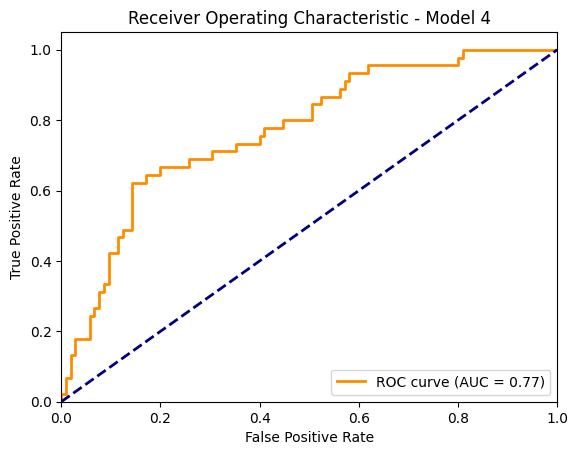

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Model 4
fpr_1, tpr_1, _ = roc_curve(y_test, y_pred_prob_4)
roc_auc_1 = auc(fpr_1, tpr_1)

plt.figure()
plt.plot(fpr_1, tpr_1, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Model 4')
plt.legend(loc="lower right")
plt.show()


# **Lift & Stability- Model 4**

In [ ]:
#  Compute Lift & Stability – Model 4

# Decile binning
df_lift_4['decile'] = pd.qcut(df_lift_4['score'], 10, labels=False, duplicates='drop')

# Aggregate stats
decile_stats_4 = df_lift_4.groupby('decile')['actual'].agg(['count', 'sum', 'mean'])
decile_stats_4 = decile_stats_4.rename(columns={'sum': 'bads', 'mean': 'bad_rate'})

# Metrics
overall_bad_rate_4 = df_lift_4['actual'].mean()
lift_4 = decile_stats_4.iloc[0]['bad_rate'] / overall_bad_rate_4
stability_4 = decile_stats_4.iloc[0]['bad_rate'] - decile_stats_4.iloc[-1]['bad_rate']

# Print
print(f"Overall BAD rate: {overall_bad_rate_4:.4f}")
print(f"Top Decile BAD rate: {decile_stats_4.iloc[0]['bad_rate']:.4f}")
print(f"Bottom Decile BAD rate: {decile_stats_4.iloc[-1]['bad_rate']:.4f}")
print(f"Lift (Top 10%): {lift_4:.2f}")
print(f"Stability (Top vs Bottom): {stability_4:.2f}")

# Table
decile_stats_4


Overall BAD rate: 0.3000
Top Decile BAD rate: 0.0000
Bottom Decile BAD rate: 0.6000
Lift (Top 10%): 0.00
Stability (Top vs Bottom): -0.60


,count,bads,bad_rate
decile,,,
0,15,0,0.000000
1,15,2,0.133333
2,15,1,0.066667
3,15,5,0.333333
4,15,4,0.266667
5,15,2,0.133333
6,15,3,0.200000
7,15,9,0.600000
8,15,10,0.666667


# **Overall Score**

In [ ]:
#  Store Metric Values for Scoring – Model 4
test_acc_4 = 0.7800
lift_4 = 0.00
stability_4 = -0.60

#  Compute Score for Model 4
acc_score_4 = 1 if test_acc_4 >= 0.75 else 0
lift_score_4 = 1 if lift_4 >= 2.0 else 0
stab_score_4 = 1 if stability_4 >= 0.5 else 0

overall_score_4 = (acc_score_4 * 0.5) + (lift_score_4 * 0.3) + (stab_score_4 * 0.2)
print(f"Model 4 Overall Score: {overall_score_4:.2f}")


Model 4 Overall Score: 0.50
